## Packages

In [11]:
import time
import timeit
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
#import seaborn as sns

from math import sqrt

import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from scipy import stats

#%matplotlib inline
#sns.set_theme(style="white")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

## Load data

In [9]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

### ETL 5 minutes

In [10]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df = df.set_index('Date')
df_5 = df.resample('5T').mean()
df_5.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5547.831152,4353.258496,4927.916309,1355.909058,1697.601026,3396.820703,920.982605
2010-01-01 00:05:00,5535.618164,4348.893457,4916.344433,1353.716626,1699.889233,3397.829590,918.181799
2010-01-01 00:10:00,5529.010351,4331.776856,4897.709473,1346.924121,1697.138647,3424.317334,916.371033
2010-01-01 00:15:00,5514.982032,4330.051758,4879.650098,1346.241382,1705.324194,3421.112500,916.161291
2010-01-01 00:20:00,5472.567285,4314.503906,4863.172266,1334.846802,1674.401562,3409.312451,914.513721


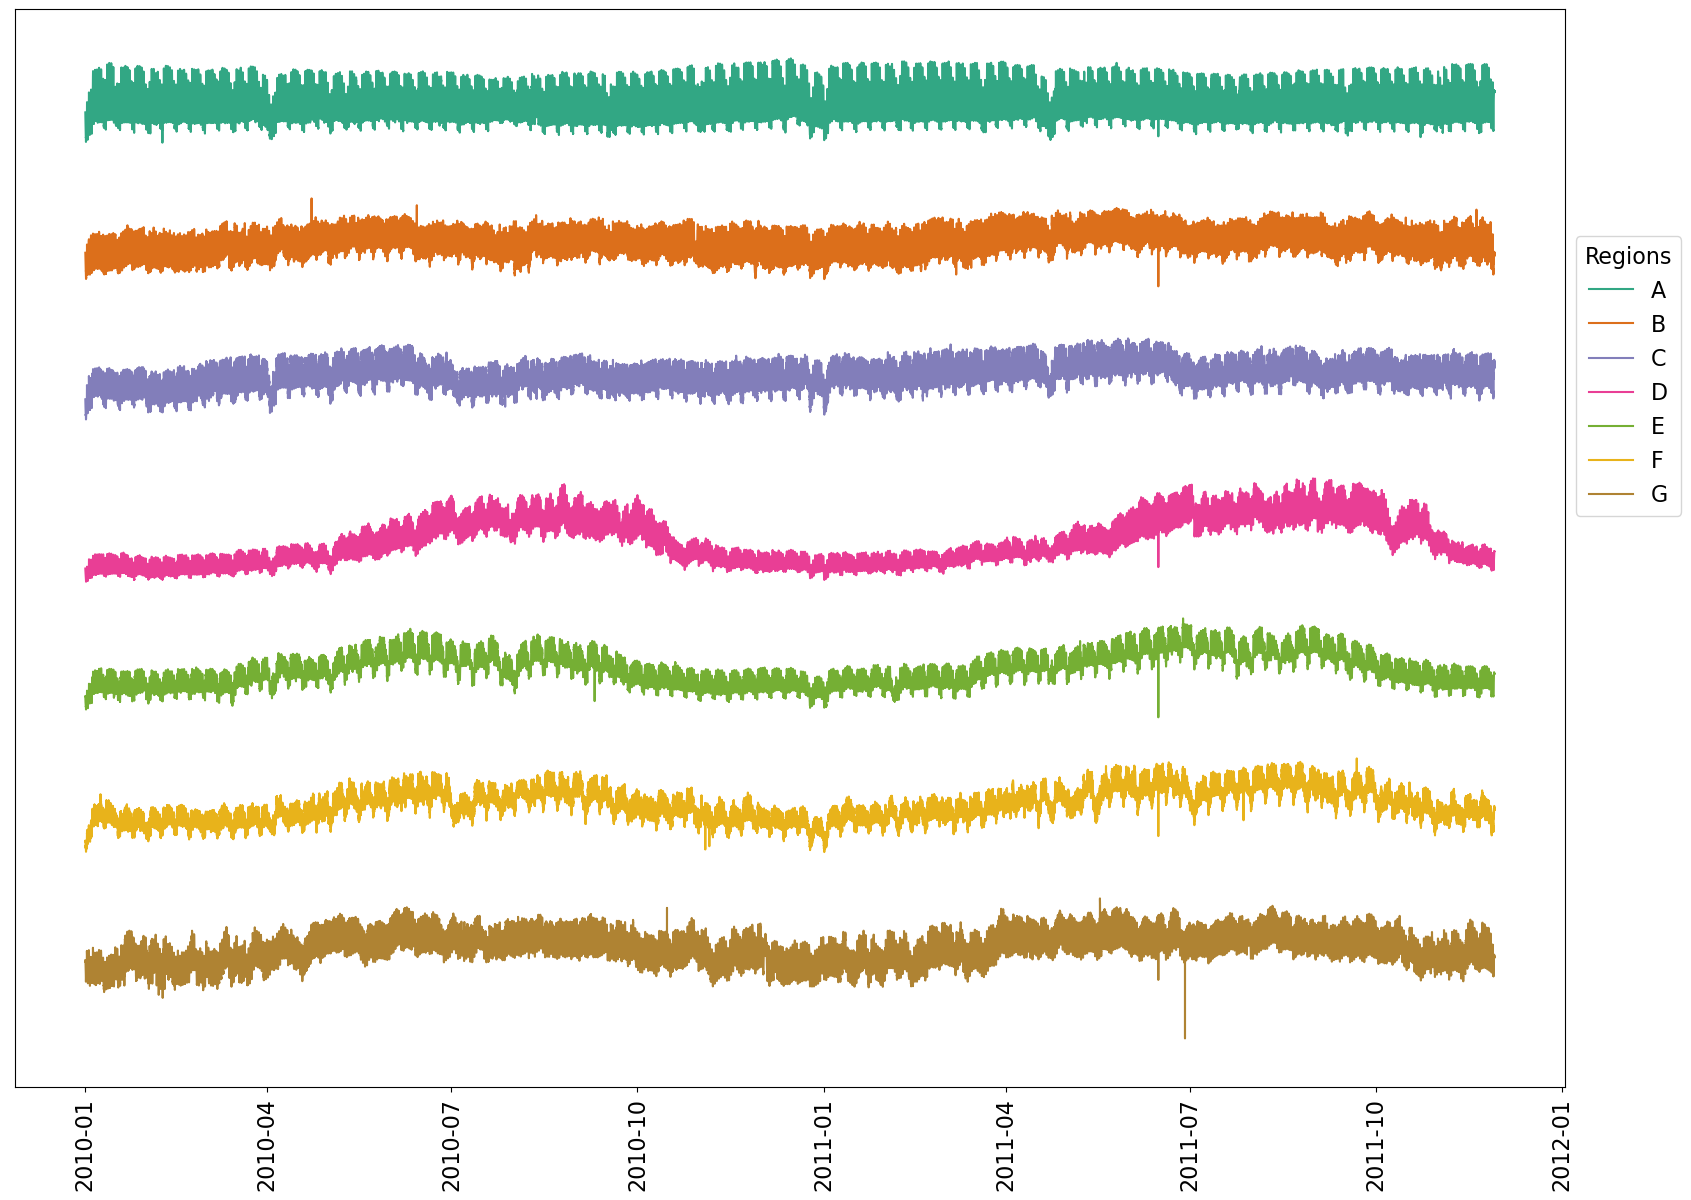

In [12]:
regions = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
if  True:
  i = 0
  j = 0
  cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
  fig, ax = plt.subplots(figsize=(20,14))
  for ts in df_5:
    max_t = df_5[ts].max()
    plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label=regions[i], alpha=.9)
    i += 1
    j -= 1
  plt.yticks([])
  plt.xticks(rotation=90, fontsize=16)
  plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16}, title="Regions", title_fontsize=16)
  #plt.savefig('series.pdf', bbox_inches = 'tight')
  plt.show()

## Functions

### Sample selection

In [ ]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [ ]:
def diff(list1,list2):
    difference = []
    zip_object = zip(list1, list2)
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    return difference

In [ ]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [ ]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## We sort the 'pi' values and the largest one is selected.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## We sort the 'pi' values and select the largest
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)  
        prediction_Y2 = results.predict(X_2)
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [ ]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1,max_iter=10000)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2    
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2

In [ ]:
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)
    return prediction_Y2   

In [ ]:
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    pl = PLSRegression(n_components=1)
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    la = Lasso(alpha=0.1)    
    pc = make_pipeline(PCA(n_components=1), LinearRegression())
    pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    la.fit(X, Y)
    pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr),("ri",ri),("la",la),("pc",pc)]) #,("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    return prediction_Y2   

In [ ]:
def euclidean(neig1, neig2):
	distance = 0.0
	for i in range(len(neig1)):
		distance += (neig1[i] - neig2[i])**2
	return sqrt(distance)

In [ ]:
#https://thispointer.com/python-how-to-append-a-new-row-to-an-existing-csv-file/#:~:text=Open%20our%20csv%20file%20in,in%20the%20associated%20csv%20file
from csv import writer
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
# a=1234566; b=987
# row = [a,b]
# append_list_as_row('test.csv',row)

### Forecast

In [ ]:
def analogo_knn(serie,vsele,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLSstep',verbose=False):
# vesele   : Size of the selection window / Tamanio de la ventana de selección
# k        : Number of neighbours to search for k / Número de vecinos a buscar k
# tol      : Window size tolerance for neighbour selection / Tolerancia de tamaño de ventanas para seleccion de vecinos
# typedist : distance measure, 'euclidian' or 'pearson' or 'dtw' / medida de distancia, 'euclidian' o 'pearson' o 'dtw' 
    t_o = time.time()
    n = len(serie) 

## STEP 1: Selection of the windows with the highest correlation.

    ## Calculate the distance between all neighbors.
    distances = []
    Y = serie[n-vsele:n]           ## latest data
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## We calculate the neighbourhood by distance from smallest to largest and the positions are saved.
    if typedist == 'pearson':
        ## In the Pearson backwards case, we are interested in the indices with the highest correlation in Pearson backwards ordering.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## We calculate the k nearest neighbors and save the positions.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## if we already had a position in the list that passed the tolerance, we no longer save it
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## save new neighbor
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## position of k nearest neighbors

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

## STEP 2: Regression between nearest neighbors 'X' and last window 'Y'

    ## Define our regressors
    X   = (neighbors.T ).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLSstep':
        prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Gradiant boosting regression --
    if typereg == 'Boosting':
        prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Bagging regression --
    if typereg == 'Bagging':
        prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Linear regression --
    if typereg == 'LinearReg':
        prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ada boosting --
    if typereg == 'AdaBoost':
        prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Bayesian Ridge --
    if typereg == 'BayesRidge':
        prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Lasso regression --
    if typereg == 'LassoReg':
        prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ridge regression --
    if typereg == 'RidgeReg':
        prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)

    ## -- PLS Regression --
    if typereg == 'PLS':
        prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)
        prediction_Y2 = prediction_Y2.flatten()

    ## -- PCA Regression --
    if typereg == 'PCR':
        prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- Voting regression with ensemble models -- 
    if typereg == 'VotingEnsemble':
        prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)

    ## -- Voting regression with linear model -- 
    if typereg == 'VotingLinear':
        prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
        
    ## -- Random forrest regression with GridSearchCV--
    #if typereg == 'AutoRF':
    #    prediction_Y2 = AutoRF(X, Y, X_2,labels_=positions,typedist_=typedist,verbose_=verbose)        

    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Forecast - ' + typedist+' - ' + typereg ,'Demand','Time',8,5,'fig_t16_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o
    fail_=False
    if len(prediction_Y2) == 0:
        prediction_Y2=[serie[-1]] * vsele
        fail_=True
        print(">>> analogo_knn: Forecast not calculated.")

    ## Draw an example of an analogous space with X, X' and Y,Y'
    if False:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.legend(['First line', 'Second line'])
        serie1=serie[positions[0]:positions[0]+2*vsele]
        serie2=serie[positions[1]:positions[1]+2*vsele]
        serie3=serie[positions[2]:positions[2]+2*vsele]
        serie4=serie[positions[3]:positions[3]+2*vsele]
        serie5=serie[positions[4]:positions[4]+2*vsele]
        serie6=serie[positions[5]:positions[5]+2*vsele]
        ax.plot(serie1, label='X$_1$')
        ax.plot(serie2, label='X$_2$')
        ax.plot(serie3, label='X$_3$')
        ax.plot(serie4, label='X$_4$')
        ax.plot(serie5, label='X$_5$')
        ax.plot(serie6,label='X$_6$')
        ax.plot(Y,label='Y', linewidth=3, color='r')   
        c = np.concatenate((Y,prediction_Y2), axis=0)   
        ax.plot(c, label='$Y\'$', linewidth=3, color='r',linestyle='--')      
        plt.legend()
        plt.axvline(x = vsele,linestyle='-.')
        ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='High correlation windows'
        ax.grid()

        fig.savefig('test'+str(random.randint(1,30000))+'.pdf')
        plt.show()

    return prediction_Y2, t_sel, t_reg, fail_, positions

In [ ]:
## Persistence forecasting
def persistence(serie, n=1):
  out = [serie[-1] * n]
  return(out)

### Utilities

In [13]:
## Function that given a datetime, returns its position in the series.
def get_index_day(df,day,month,year):
    df_i = df.reset_index()  ## Integer indices are added.
    idxo = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[ 0]
    idxf = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[-1]
    return(idxo.name, idxf.name)

In [ ]:
def get_day_from_index(df, indices, forecast):
    """
    Parameters
    ----------
    df : DataFrame
        Original dataframe of the timeseries
    indices : array
        Array of indices
    
    Returns
    -------
    DataFrame
        A DataFrame of dates
    """
    df_i = df.reset_index()  ## Integer indices are added.
    sel_date = df_i.iloc[indices].Date
    t = pd.concat([sel_date.reset_index(), pd.Series(forecast)], axis=1)
    t = t.rename(columns={0 : 'value'})
    return(t)

# Prepare cross-validation for testing

We will use the methodology proposed by Rob J Hyndman [cross-validation in time series](https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
), that is a training dataset of four months followed by a testing dataset of the next month.


In [ ]:
## https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
## ... year 2010                                                                                                    year 2011
## ... january···february···march···april···may···june···july···august···september···october···november···december···january···february···march···april···may···june···july···august···september···october···november
##    |                                   |      |
##    |<------------- train ------------->|<test>|
##    |<-january·february···march···april->|<may>|
##            |<-february···march···april···may->|<june>|
##                      |<- march···april···may···june ->|<-july->|
##                              |<- april···may···june···july->|<-august->|
##                                     |<-- may···june···july···august->|<-september->|
##                                             |<-june···july···august···september->|<-october->|
##                                                    |<-july···august···september···october->|<-november->|
##                                                           |<-august···september···october···november->|<-december->| ...

df_5_month = df_5.copy()
df_5_month.reset_index(inplace=True)
# https://stackoverflow.com/a/25149272
df_5_month['month'] = df_5_month['Date'].dt.month
df_5_month['year' ] = df_5_month['Date'].dt.year
df_5_month = df_5_month.drop_duplicates(['month', 'year'])
df_5_month.index

In [ ]:
## Get the positions
#  to : training initial position
#  tt : testing initial position
#  tf : time series final position
# month_i = df_5_month.index
# r = range(len(month_i) - 5)
# tuplas = []
# for i in r:
#   tuplas.append((
#     # 1 ene       30 abril            31 may
#     month_i[i], month_i[i + 4] - 1, month_i[i + 5] - 1
#   ))
# tuplas.append((157248, 192671, 200638))
# tuplas

## Public holidays

In [ ]:
serie='SERIE1'
print(get_index_day(df_5[serie],10,5,2010))   ## mothers day 2010
print(get_index_day(df_5[serie],10,5,2011))   ## mothers day 2011
print(get_index_day(df_5[serie],24,12,2010))  ## christmas 2010
print(get_index_day(df_5[serie],31,12,2010))  ## new year 2011
print(get_index_day(df_5[serie],1,1,2011))    ## new year 2011

# Parameter and series selection

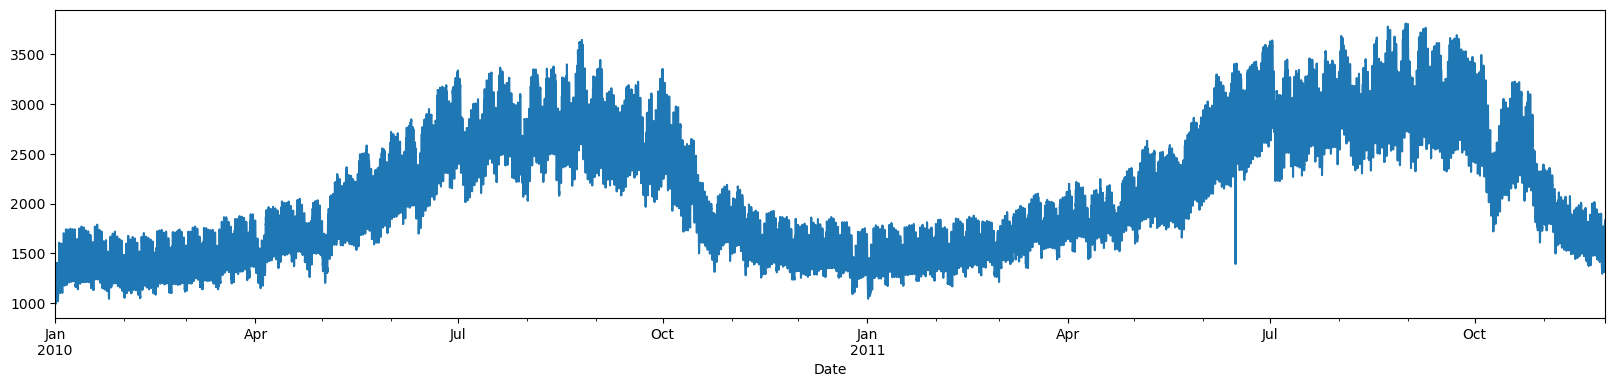

In [15]:
serie4 = df_5.SERIE4
plt.figure(figsize=(20, 4))
#plt.savefig('series1.pdf', bbox_inches = 'tight')
serie4.plot()
plt.show()

In [16]:
df_serie4 = serie4.reset_index()
df_serie4.columns = ['date', 'value']
df_serie4

,date,value
0,2010-01-01 00:00:00,1355.909058
1,2010-01-01 00:05:00,1353.716626
2,2010-01-01 00:10:00,1346.924121
3,2010-01-01 00:15:00,1346.241382
4,2010-01-01 00:20:00,1334.846802
...,...,...
200634,2011-11-28 15:30:00,1824.311914
200635,2011-11-28 15:35:00,1832.722339
200636,2011-11-28 15:40:00,1830.256812
200637,2011-11-28 15:45:00,1824.559302


In [ ]:
## ene2010... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·nov2011
##                |                                               |       |           |
##                |                                               |<-n_p->|           |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt   ...j=0...      tf 

n_p       = 30         ## Number of periods per step (Two and half hour)
vsele     = 288        ## Number of periods in a window (a day)
namefile  = 'forecast'
monthyear = 'jun2010'

##  21 Junio 2010       - 21 Septiembre 2010   Verano
##  21 Septiembre 2010  - 21 Diciembre 2010    Otoño
##  21 Diciembre 2011   - 21 Marzo 2011        Invierno
##  21 Marzo 2011       - 21 Junio 2011        Primavera

In [ ]:
df_serie4_summer = df_serie4[(df_serie4.date >='2010-06-21')&(df_serie4.date <'2010-09-21')]

In [ ]:
# Each season
df_serie4_summer = df_serie4[(df_serie4.date >='2010-06-21')&(df_serie4.date <'2010-09-21')]
df_serie4_autum  = df_serie4[(df_serie4.date >='2010-09-21')&(df_serie4.date <'2010-12-21')]
df_serie4_winter = df_serie4[(df_serie4.date >='2010-12-21')&(df_serie4.date <'2011-03-21')]
df_serie4_spring = df_serie4[(df_serie4.date >='2011-03-21')&(df_serie4.date <'2011-06-21')]

## Unit test per season

In [ ]:
df_serie4_summer

In [ ]:
plt.figure()
plt.plot(df_serie4_summer.date, df_serie4_summer.value, label = 'Summer')
plt.plot(df_serie4_autum.date , df_serie4_autum.value , label = 'Autum')
plt.plot(df_serie4_winter.date, df_serie4_winter.value, label = 'Winter')
plt.plot(df_serie4_spring.date, df_serie4_spring.value, label = 'Spring')
plt.xticks(rotation = 90)
plt.legend()
#plt.savefig('series2.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Data selection for season; i.e. summer
indices = df_serie4_summer.date - pd.DateOffset(months=4) # select indices
df_serie4_summer_data = df_serie4[
  (df_serie4.date >= indices.values[0]) & (df_serie4.index < df_serie4_summer.index[0])
]
df_serie4_summer_data # train

In [ ]:
t0 = df_serie4_summer_data.iloc[0]  # initial time
tt = df_serie4_summer_data.iloc[-1] # time to
tf = df_serie4_summer.iloc[-1]      # final time

In [ ]:
plt.figure()
plt.plot(df_serie4_summer_data.date, df_serie4_summer_data.value, label = 'Train')
plt.plot(df_serie4_summer.date, df_serie4_summer.value, label = 'Test')
plt.xticks(rotation = 90)
plt.axvline(x = t0.date, c = 'red')
plt.axvline(x = tt.date, c = 'red')
plt.axvline(x = tf.date, c = 'red')
plt.legend()
plt.savefig('fig:traintest.pdf', bbox_inches = 'tight')

ax.set_ylabel('Load demand MW')
plt.show()

In [ ]:
# Access index of t0, etc ╰（‵□′）╯
t0.name

In [ ]:
def train_test_season(data, d0 = '2010-06-21', df = '2010-09-21', do = 4, verbose = False):
  # d0: start date
  # df: final date
  # d0: offset date in months
  # df_r: df result
  # t0: start train index
  # tt: end train index / start test index
  # tf: end test index
  df_r = data[(data.date >= d0) & (data.date < df)]
  if verbose:
    plt.figure()
    plt.plot(df_r.date, df_r.value, label = 'df_r')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

  # Data selection for range(d0, df)
  indices = df_r.date - pd.DateOffset(months = do) # select indices
  df_r_data = df_serie4[
    (df_serie4.date >= indices.values[0]) & (df_serie4.index < df_r.index[0])
  ]
  t0 = df_r_data.iloc[0]  # initial time
  tt = df_r_data.iloc[-1] # time to
  tf = df_r.iloc[-1]      # final time

  if verbose:
    plt.figure()
    plt.plot(df_r_data.date, df_r_data.value, label = 'Train')
    plt.plot(df_r.date, df_r.value, label = 'Test')
    plt.xticks(rotation = 90)
    plt.axvline(x = t0.date, c = 'red')
    plt.axvline(x = tt.date, c = 'red')
    plt.axvline(x = tf.date, c = 'red')
    plt.legend()
    plt.show()
  
  return (t0, tt, tf)

In [8]:
t0, tt, tf = train_test_season(df_serie4, d0 = '2010-06-21', df = '2010-09-21', do = 4, verbose = False)
#print(t0, tt, tf)
print(t0.name, tt.name, tf.name) # indices
t0=t0.name
tt=tt.name
tf=tf.name

NameError: name 'train_test_season' is not defined

## Nixtla 

In [3]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, SeasonalNaive

c:\Users\user\miniconda3\envs\statsforecast\lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [33]:
df_nixtla = df_serie4.copy()
df_nixtla.reset_index(inplace=True)
df_nixtla.columns = ['unique_id', 'ds', 'y']
df_nixtla.unique_id = 'PAPA'
df_nixtla

,unique_id,ds,y
0,PAPA,2010-01-01 00:00:00,1355.909058
1,PAPA,2010-01-01 00:05:00,1353.716626
2,PAPA,2010-01-01 00:10:00,1346.924121
3,PAPA,2010-01-01 00:15:00,1346.241382
4,PAPA,2010-01-01 00:20:00,1334.846802
...,...,...,...
200634,PAPA,2011-11-28 15:30:00,1824.311914
200635,PAPA,2011-11-28 15:35:00,1832.722339
200636,PAPA,2011-11-28 15:40:00,1830.256812
200637,PAPA,2011-11-28 15:45:00,1824.559302


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = StatsForecast(
    models = [AutoARIMA(season_length = 288)],
    freq = '5T',
    n_jobs = 8
)

sf.fit(df_nixtla.iloc[50000:51000])
sf.predict(h = 12, level = [95])

In [ ]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

## References

- https://nixtla.github.io/statsforecast/examples/electricityloadforecasting.html
- https://nixtla.github.io/statsforecast/models.html#autoarima
- https://towardsdatascience.com/fast-time-series-forecasting-with-statsforecast-694d1670a2f3